# Diode Clipper

## Introduction

In this example, we will simulate a classic **Diode Clipper (Limiter)** circuit. This circuit is a fundamental building block in analog signal processing, used to protect sensitive components from voltage spikes or to shape waveforms by "clipping" signal peaks.

From a simulation perspective, the Diode Clipper serves as a critical benchmark for testing non-linear solvers. As the input voltage crosses the diode's forward-bias threshold, the component's impedance changes rapidly—spanning orders of magnitude from "off" to "on." This behavior creates a stiff system of differential equations, requiring a robust, adaptive step-size controller to maintain numerical stability.

In [1]:
import jax
import jax.numpy as jnp
import diffrax

from circulus.components.electronic import Resistor, Diode, VoltageSourceAC
from circulus.compiler import compile_netlist
from circulus.solvers import analyze_circuit, setup_transient
import time

import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

KLUJAX_RS DEBUG MODE.


## Defining the Netlist

In [2]:
vpp = 2.0
net_dict ={
    "instances": {
        "GND": {"component":"ground"},
        "Vin": {"component":"source_voltage", "settings":{"V": vpp, "freq": 1e3,}},
        "R1":  {"component":"resistor", "settings":{"R": 1000.0}},
        "D1":  {"component":"diode", "settings":{'Is':1e-14,}},
        "D2":  {"component":"diode", "settings":{'Is':1e-14,}},
    },
    "connections": {
        "GND,p1": ("Vin,p2", "D1,p2", "D2,p1"),
        "Vin,p1": "R1,p1",
        "R1,p2":  ("D1,p1", "D2,p2"),
    },
}

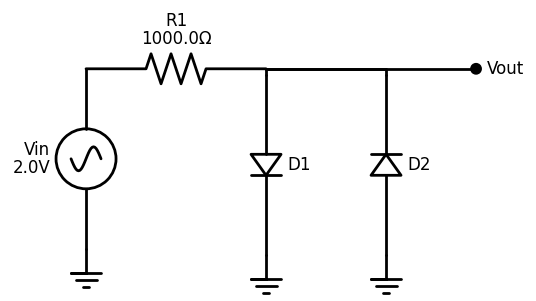

In [3]:
import schemdraw
import schemdraw.elements as elm

# --- Helper to extract labels from your dict ---
def get_label(instance_id):
    """Generates a label string based on the instance settings."""
    inst = net_dict["instances"][instance_id]
    comp_type = inst["component"]
    settings = inst.get("settings", {})
    
    label = f"{instance_id}"
    if comp_type == "resistor":
        label += f"\n{settings.get('R', '')}Ω"
    elif comp_type == "source_voltage":
        label += f"\n{settings.get('V', '')}V"
    return label

# --- Drawing the Circuit ---
with schemdraw.Drawing() as d:
    d.config(fontsize=12, inches_per_unit=0.6)

    # Main series path
    gnd = d.add(elm.Ground())
    source = d.add(elm.SourceSin().label(get_label("Vin")).up())
    d.add(elm.Resistor().right().at(source.end).label(get_label("R1")))
    junction = d.here

    # Branch 1 (D1 - Forward)
    d.add(elm.Line().down().length(0.1))
    d.add(elm.Diode().down().label("D1", loc='bottom'))
    d.add(elm.Ground())

    # Branch 2 (D2 - Reverse)
    # Move right from junction
    d.add(elm.Line().at(junction).right().length(2)) 
    d.add(elm.Line().down().length(0.1))
    
    # Draw D2 DOWN, but reverse the symbol so it points UP
    d.add(elm.Diode().down().reverse().label("D2", loc='bottom'))
    d.add(elm.Ground())

    # Output Line
    d.add(elm.Line().at(junction).right().length(3.5))
    d.add(elm.Dot().label('Vout', loc='right'))

1. Compiling Circuit...
   System Size: 4 variables
   Port Map: {'D2,p2': 1, 'D1,p1': 1, 'R1,p2': 1, 'Vin,p2': 0, 'D1,p2': 0, 'GND,p1': 0, 'D2,p1': 0, 'R1,p1': 2, 'Vin,p1': 2}
2. Initializing Solver Strategy...
3. Solving DC Operating Point...
   DC Solution (First 5): [0. 0. 0. 0.]
4. Running Transient Simulation...
   ✅ Simulation Successful
Performed 590 steps performed in 0.49 seconds


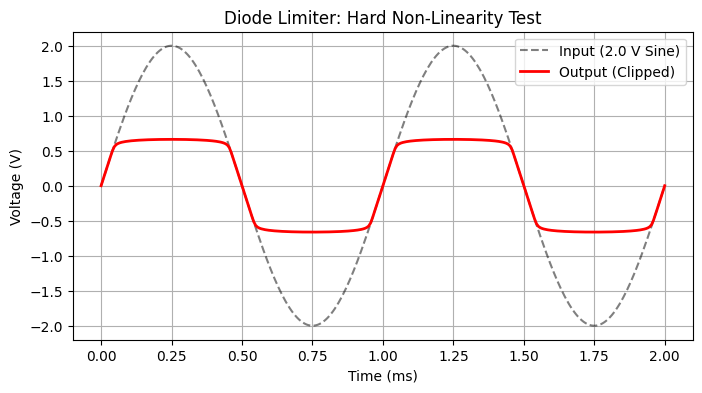

In [4]:
models_map ={
    'resistor': Resistor,
    'diode': Diode,
    'source_voltage': VoltageSourceAC,
    'ground': lambda: 0
}

print("1. Compiling Circuit...")
groups, num_vars, port_map = compile_netlist(net_dict, models_map)
print(f"   System Size: {num_vars} variables")
print(f"   Port Map: {port_map}")



print("2. Initializing Solver Strategy...")
linear_strat = analyze_circuit(groups=groups, num_vars=num_vars, backend='klu_split')

print("3. Solving DC Operating Point...")
y_guess = jnp.zeros(num_vars)
y_dc = linear_strat.solve_dc(groups, y_guess)
print(f"   DC Solution (First 5): {y_dc[:5]}")

print("4. Running Transient Simulation...")



transient_sim = setup_transient(groups, 
                                linear_strategy=linear_strat)

t_max = 2E-3
saveat = diffrax.SaveAt(ts=jnp.linspace(0, t_max, 300))

step_controller = diffrax.PIDController(
    rtol=1e-3, 
    atol=1e-6,  
    pcoeff=0.2, 
    icoeff=0.5,
    dcoeff=0.4,
    force_dtmin=True,
    dtmin=1E-8,
    dtmax=1e-5,
    error_order=2
)

start = time.time()
sol = transient_sim(t0=0, 
                    t1=t_max, 
                    dt0=1E-6*t_max, 
                    y0=y_dc,
                    saveat=saveat,
                    stepsize_controller=step_controller)
stop = time.time()

if sol.result == diffrax.RESULTS.successful:
    print("   ✅ Simulation Successful")
    print(f"Performed {sol.stats['num_steps']} steps performed in {stop-start:.2f} seconds")
    ts = sol.ts
    v_in = sol.ys[:, port_map['Vin,p1']]
    v_out = sol.ys[:, port_map['R1,p2']]

    plt.figure(figsize=(8, 4))
    plt.plot(ts*1000, v_in, 'k--', alpha=0.5, label=f'Input ({vpp} V Sine)')
    plt.plot(ts*1000, v_out, 'r-', linewidth=2, label='Output (Clipped)')
    plt.title("Diode Limiter: Hard Non-Linearity Test")
    plt.xlabel("Time (ms)")
    plt.ylabel("Voltage (V)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("   ❌ Simulation Failed")
    print(f"   Result Code: {sol.result}")